# Single layer networks

In [1]:
from functools import partial
import numpy as np

from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
nn.Linear(2, 10)(torch.randn((400, 2)).float())

tensor([[ 0.5313, -0.0197, -0.3157,  ..., -0.8574,  0.5192,  0.4360],
        [ 0.4850,  0.0531,  0.5678,  ..., -0.2140,  0.7757,  0.0971],
        [ 0.5079, -0.1861,  0.4404,  ..., -0.3535,  0.4658,  0.7779],
        ...,
        [ 0.5057,  0.2314, -0.1494,  ..., -0.6877,  0.8509, -0.2838],
        [ 0.4670, -0.4529,  1.7284,  ...,  0.5081,  0.3945,  1.3146],
        [ 0.4868, -0.1154,  0.7860,  ..., -0.0932,  0.6165,  0.5287]],
       grad_fn=<AddmmBackward>)

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Decision boundaries

### Create data

In [ ]:
class_conditional_1 = multivariate_normal(mean=[1, 1], cov=0.5)
class_conditional_2 = multivariate_normal(mean=[4, 4], cov=0.5)
class_conditional_3 = multivariate_normal(mean=[4, 1], cov=0.5)
class_conditional_4 = multivariate_normal(mean=[6, 1], cov=0.5)

In [1]:
data_1 = class_conditional_1.rvs(100)
data_2 = class_conditional_2.rvs(100)
data_3 = class_conditional_3.rvs(100)
data_4 = class_conditional_4.rvs(100)
del data_1, data_2
data = np.concatenate([data_1, data_2, data_3, data_4])
labels = np.concatenate([np.zeros(100), np.ones(100), np.ones(100)*2, np.ones(100)*3]).astype(int)
np.random.seed(42)
np.random.shuffle(data)
np.random.seed(42)
np.random.shuffle(labels)

NameError: name 'class_conditional_1' is not defined

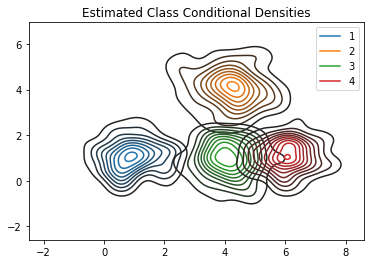

In [133]:
plt.title('Estimated Class Conditional Densities')
sns.kdeplot(data_1[:,0], data_1[:,1], label='1')
sns.kdeplot(data_2[:,0], data_2[:,1], label='2')
sns.kdeplot(data_3[:,0], data_3[:,1], label='3')
sns.kdeplot(data_4[:,0], data_4[:,1], label='4')
plt.legend()
plt.show()

In [134]:
def get_model_and_opt():
    model = nn.Linear(in_features=2, out_features=4, bias=True)
    return model.float(), optim.SGD(model.parameters(), lr=0.1)

In [135]:
def get_dl():
    torch_data, torch_labels = torch.from_numpy(data).float(), torch.from_numpy(labels).long()
    ds = TensorDataset(torch_data, torch_labels)
    dl = DataLoader(ds, batch_size=1, shuffle=True)
    return dl

In [136]:
loss_fn = nn.CrossEntropyLoss()

In [137]:
def train(num_epochs):
    model, opt = get_model_and_opt()
    dl = get_dl()
    
    losses = []
    model.train()
    for epoch in log_progress(list(range(num_epochs))):
        for xb, yb in dl:
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            losses.append(float(loss))
            opt.zero_grad()
    
    model.eval()
    yhats = []
    for xb, yb in dl:
        yhat = model(xb)
        yhats.append(yhat)
    yhats = torch.cat(yhats)
    
    return model, yhats, losses

In [138]:
trained_model, yhats, losses = train(num_epochs=10)

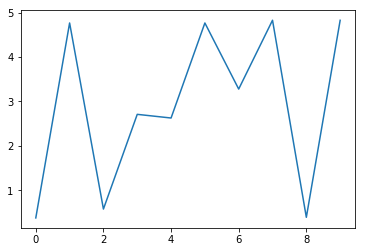

In [139]:
plt.plot(losses[::400])

In [140]:
yhats[300]

tensor([ 1.6100, -3.1776, -1.0500,  1.6679], grad_fn=<SelectBackward>)

In [148]:
yhats.argmax(axis=1).numpy()

array([3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3,
       0, 0, 3, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0,
       0, 3, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 3, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0,
       0, 0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3,

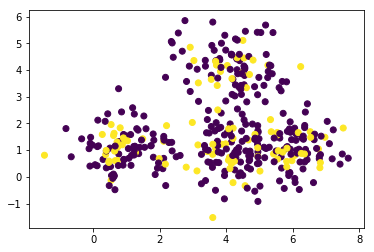

In [150]:
plt.scatter(data[:,0], data[:,1], c=yhats.argmax(axis=1).numpy())
plt.show()